# Rutherford Scattering simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import sys

In [2]:
0.2e-9/(1000*(0.197e-15))

1015.2284263959392

## Constants

In [3]:
# general constants
c = 3.0e8

# atomic properties
m_p = 938.272 # MeV/c^2
m_n = 939.565 # MeV/c^2
m_a = 2*m_p + 2*m_n
A_a = 4
Z_a = 2
Na = 6.02214076e23 #particles/mol
alpha = 1.0/137.035999 #fine structure constant-


rho_Au = 19.3 #g/cm^3
A_Au = 196.997 #g/mol
Dat_Au = np.power(rho_Au*Na/A_Au, -1/3)*0.01/(1000*(0.197e-15)) #gold inter atomic distance
th_Au = 0.16e-6 #gold foild thickness
#Nat_Au = int(h_Au*2/Dat_Au) #number of consecutive gold atoms
Z_Au = 79

# geometry
source_x = 0
source_y = 0
source_z = 0

In [4]:
print(Dat_Au)

1303.9198822824615


## Source

In [5]:
class Source():
    def __init__(self, s_x, s_y, s_z, s_r, s_a):
        self.source_x = s_x    # x position
        self.source_y = s_y    # y position
        self.source_z = s_z    # z position
        self.source_r = s_r    # radius
        self.source_a = s_a    # activity

    def GenerateParticle(self, E_k, M, N=1):
        # kinematics
        gamma = 1.0 + E_k/M
        beta  = np.sqrt(1 - 1/(gamma*gamma))
        p     = M * gamma * beta
        
        # source point of emission (polar coordinates)
        r_s = np.sqrt(np.random.uniform(0, 1, size=(N,1))) * self.source_r
        t_s = np.random.uniform(0, 1, size=(N,1)) * 2 * np.pi
        
        # source point of emission (carthesian coordinates)
        x_s = self.source_x + r_s * np.cos(t_s)
        y_s = self.source_y * np.ones((N,1))
        z_s = self.source_z + r_s * np.sin(t_s)
        
        # versor of direction (polar coordinates)
        u_pp = np.random.uniform(0, 1, size=(N,1)) * np.pi                 # momentum: phi   (0< phi <pi)
        u_pt = np.arccos(2 * np.random.uniform(0, 1, size=(N,1)) - 1.0)    # momentum: theta (0<theta<pi)
        
        # versor of direction (carthesian coordinates)
        u_px = np.cos(u_pp)*np.sin(u_pt)    # momentum : x
        u_py = np.sin(u_pp)*np.sin(u_pt)    # momentum : y
        u_pz = np.cos(u_pt)                 # momentum : z
        
        # momentum of alphas (carthesian coordinates)
        px = u_px * p
        py = u_py * p
        pz = u_pz * p
        
        return [
            np.hstack((r_s,t_s)),
            np.hstack((x_s,y_s,z_s)),
            np.hstack((r_s,t_s)),
            np.hstack((u_px,u_py,u_pz)),
            np.hstack((px,py,pz))
        ]

In [6]:
source = Source(0,0,0,1,300)
source.GenerateParticle(4.8, m_a, 1)

[array([[0.37497088, 4.9252957 ]]),
 array([[ 0.07923205,  0.        , -0.36650436]]),
 array([[0.37497088, 4.9252957 ]]),
 array([[ 0.35078415,  0.7492173 , -0.56180416]]),
 array([[  66.62822398,  142.30693974, -106.70953599]])]

## Particle

In [7]:
class Particle():
    def __init__(self, source, E_k, M, N=1):
        self.source = source
        particles = source.GenerateParticle(E_k, M, N)
        self.particle_x  = particles[1][:,0]
        self.particle_y  = particles[1][:,1]
        self.particle_z  = particles[1][:,2]
        self.particle_px = particles[4][:,0]
        self.particle_py = particles[4][:,1]
        self.particle_pz = particles[4][:,2]
        self.particle_m  = M
        self.particle_E  = E_k*np.ones((N,))
    
    def FreeEvolutionDx(self, dx):
        self.particle_x += dx
        dt = dx*self.particle_m/self.particle_px
        self.particle_z += dt*self.particle_pz/self.particle_m
        self.particle_y += dt*self.particle_py/self.particle_m
   
    def FreeEvolutionDy(self, dy):
        self.particle_y += dy
        dt = dy*self.particle_m/self.particle_py
        self.particle_x += dt*self.particle_px/self.particle_m
        self.particle_z += dt*self.particle_pz/self.particle_m
   
    def FreeEvolutionDz(self, dz):
        self.particle_z += dz
        dt = dz*self.particle_m/self.particle_pz
        self.particle_x += dt*self.particle_px/self.particle_m
        self.particle_y += dt*self.particle_py/self.particle_m
        
    def FreeEvolutionDt(self, dt):
        self.particle_x += dt*3.0e8*self.particle_px/self.particle_m
        self.particle_y += dt*3.0e8*self.particle_py/self.particle_m
        self.particle_z += dt*3.0e8*self.particle_pz/self.particle_m
        
    def TimeEvolution(self, F, dt):
        #v(i+1)= vi +ai*dt
        #x(i+1)= xi +v(i+1)*dt 
        # x_(i+1) = x_i + t_i*px_i/M
        # px_(i+1) = px_i + F_i*t_i
        pass
    
    def Collimate(self, collimator):
        mask = collimator.Passage(self.particle_x, self.particle_z)
        self.particle_x  = self.particle_x  [mask]
        self.particle_y  = self.particle_y  [mask]
        self.particle_z  = self.particle_z  [mask]
        self.particle_px = self.particle_px [mask]
        self.particle_py = self.particle_py [mask]
        self.particle_pz = self.particle_pz [mask]
        self.particle_E  = self.particle_E  [mask]
        
    def Interact(self, target):
        a, tau = target.Scatter(self.particle_E, Z_a) 
        ct = np.cos(tau) 
        st = np.sin(tau) 
        ca = np.cos(np.pi/2 - a)
        sa = np.sin(np.pi/2 - a)
        # y rotation for alpha z rotation tau
        old_px = np.copy(self.particle_px)
        old_py = np.copy(self.particle_py)
        old_pz = np.copy(self.particle_pz)
        self.particle_px = + ct*ca*old_px - st*old_py + ct*sa*old_pz
        self.particle_py = + st*ca*old_px + ct*old_py + st*sa*old_pz
        self.particle_pz = -    sa*old_px             +    ca*old_pz
        return tau
        # self.particle_px = + ct*ca*old_px - st*ca*old_py +    sa*old_pz
        # self.particle_py = + st*   old_px + ct*   old_py +     0*old_pz
        # self.particle_pz = - ct*sa*old_px + st*sa*old_py +    ca*old_pz
        # y rotation for alpha x rotation tau       
        #self.particle_px = +    ca*self.particle_px                       +    sa*self.particle_pz
        #self.particle_py = + st*ca*self.particle_px + ct*self.particle_py - st*ca*self.particle_pz
        #self.particle_pz = - ct*sa*self.particle_px + st+self.particle_y  + ct*ca*self.particle_pz        
    
    def GetTrack(self):
        return [
            self.particle_x,
            self.particle_y,
            self.particle_z
        ]
    
    def TrackCylinder(self, r, old_x, old_y, old_z):
        a = np.power(self.particle_x-old_x,2) + np.power(self.particle_y-old_y,2)
        b = old_x * (self.particle_x-old_x) + old_y * (self.particle_y-old_y)
        t = (-b + np.sign(self.particle_y) * np.sqrt(np.power(b,2) + a*r*r)) / a
        
        x_cyl = old_x + t * (self.particle_x-old_x)
        y_cyl = old_y + t * (self.particle_y-old_y)
        z_cyl = old_z + t * (self.particle_z-old_z)
        
        t_cyl = np.arccos(x_cyl/r)
        
        return [x_cyl, y_cyl, z_cyl, t_cyl]

In [8]:
particles = Particle(source, 4.8, m_a)

In [9]:
particles.particle_x

array([0.00537021])

## Collimator

In [10]:
class Collimator():
    def __init__(self, c_x, c_y, c_z, c_w, c_h):
        self.collimator_x = c_x    # x origin    +++++   ^z
        self.collimator_y = c_y    # y origin    +   +   |
        self.collimator_z = c_z    # z origin    o++++   x--->x
        self.collimator_w = c_w    # width
        self.collimator_h = c_h    # height
        
    def Passage(self, x, z):
        # if x>self.collimator_x and x <self.collimator_x+self.collimator_w and \
        #    y>self.collimator_y and y <self.collimator_y+self.collimator_h:
        #     return True
        # else:
        #     return False
        col_x = np.ones(x.shape) * self.collimator_x
        col_z = np.ones(z.shape) * self.collimator_z
        mask_x = np.logical_and(x>col_x, x<col_x+self.collimator_w)
        mask_z = np.logical_and(z>col_z, z<col_z+self.collimator_h)
        mask   = np.logical_and(mask_x, mask_z)
        return mask

## Target scatter

In [11]:
# https://robolab.unex.es/wp-content/plugins/papercite/pdf/rutherford-simple-scattering.pdf
#classical treatment
#given a particle i generate 2 numbers x,y in (a, Dat/2)
# Dat is the inter atomic distance Dat=(rho*NA/A)^-1/3
#rho density A atomic mass NA avogadros number
# the impact parameter is sqrt(x2+y2)


class Target():
    def __init__(self, t_x, t_y, t_z, t_t, t_r, t_A, t_Z):
        self.target_x = t_x
        self.target_y = t_y
        self.target_z = t_z
        self.target_t = t_t #target thickness
        self.target_r = t_r #target density (rho)
        self.target_A = t_A #target atomic mass
        self.target_Z = t_Z #target effective atomic number
        self.target_D = np.power(t_r*Na/t_A, -1.0/3.0)*0.01*1.0e9
        # np.power(t_r*Na/t_A, -1.0/3.0)*0.01/(1000*(0.197e-15))#-15 giusto #target interatomic distance
    
    def Scatter(self, E, q): #energy and charge of projectyle
        x = np.random.uniform(-self.target_D/2,self.target_D/2, E.shape)
        y = np.random.uniform(-self.target_D/2,self.target_D/2, E.shape)
        a = 2*np.pi*np.random.uniform(0,1)#np.arctan(x/y)
        b = np.sqrt(np.square(x)+np.square(y))
        k_2tb = 2.3651e-5/b#q*self.target_Z / (2*E*b) # q*self.target_Z*alpha / (2*E*b)
        theta = 2*np.arctan(k_2tb) #np.pi - 2*np.arccos(k_2tb / np.sqrt(1 + np.square(k_2tb)))
        #print("k2tb: ",np.mean(k_2tb), " mean theta ",np.mean(theta))
        tau = np.arctan(np.sin(theta)/(np.cos(theta)+ A_a/self.target_A))
        #print(np.mean(tau))
        # print(np.mean(np.abs(tau)))
        # print(np.mean(np.abs(a)))
        return a, tau

In [12]:
r = np.power(rho_Au*Na/A_Au, -1/3)*0.01*1e9
x = np.random.uniform(-r/2,r/2, 10000)
y = np.random.uniform(-r/2,r/2, 10000)
a = np.arctan(x/y)

In [13]:
plt.hist(np.asnumpy((a)), bins=50)
plt.show()

AttributeError: module 'numpy' has no attribute 'asnumpy'

In [203]:
e0 = 8.854e-12
e = 1.602e-19
eA = 4.8 * 1e6 * e
k = 2*79*e*e/(4*np.pi*e0*2*eA)*1e9
k

2.3697306405560684e-05

In [204]:
np.power(19.6*Na/196.9, -1.0/3.0)*0.01*1.0e9

array(0.25551295)

## Test

### Geometry and evolution

In [14]:
import cupy as np
np.cuda.Device(0).use()

#import numpy as np

In [207]:
#import numpy as np

In [209]:
N = 10000000#10000000
k = 100#1000
patience = 1


x_cyl = np.array([])
y_cyl = np.array([])
z_cyl = np.array([])
t_cyl = np.array([])
tau_c = np.array([])

source = Source(0, -0.05, 0, 0.003, 300)
col1 = Collimator(-0.0005, -0.04, -0.0015, 0.001, 0.003)
col2 = Collimator(-0.0005,  0.00, -0.0015, 0.001, 0.003)
target = Target ( 0.0, 0.0, 0.0, th_Au, rho_Au, A_Au, Z_Au)

start = time.time()
for i in range(k):
    if ( i % patience == 0 ):
        sys.stdout.write("\rCompleteness : "+str(round(i/k*100,1))+"%")
    particles = Particle(source, 4.8, m_a, N)

    particles.FreeEvolutionDy(0.01)
    particles.Collimate(col1)
    particles.FreeEvolutionDy(0.04)
    particles.Collimate(col2)
    for i in range(64000):
        tau = particles.Interact(target)
    tau_c = np.hstack((tau_c,tau))

    x_old = copy.deepcopy(particles.particle_x)# track1[0]# np.copy(particles.particle_x)
    y_old = copy.deepcopy(particles.particle_y)# track1[1]# np.copy(particles.particle_y)
    z_old = copy.deepcopy(particles.particle_z)# track1[2]# np.copy(particles.particle_z)

    # particles.FreeEvolutionDy(0.05)
    
    particles.FreeEvolutionDt(1e-8)

    track = particles.TrackCylinder(0.05, x_old, y_old, z_old)

    x_cyl = np.hstack((x_cyl,track[0]))
    y_cyl = np.hstack((y_cyl,track[1]))
    z_cyl = np.hstack((z_cyl,track[2]))
    t_cyl = np.hstack((t_cyl,track[3]))
    
    del particles
    del x_old
    del y_old
    del z_old

print("\nCompleted")  
print(time.time()-start)

Completeness : 99.0%
Completed
574.2968430519104


In [210]:
t_cyl.shape

(31671,)

### Plot of the track

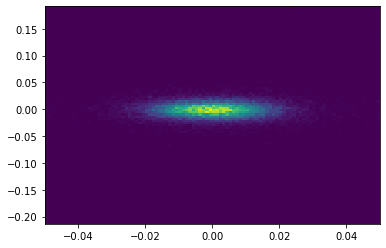

In [212]:
plt.hist2d(x_cyl, z_cyl, bins=[100,100])
#plt.hist2d(np.asnumpy(x_cyl), np.asnumpy(z_cyl), bins=[100,100])
plt.show()

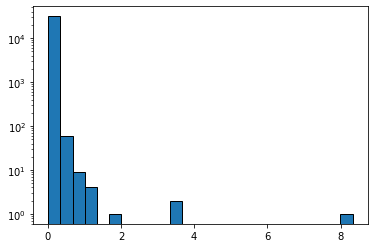

In [215]:
#N, edges,_ = plt.hist(np.asnumpy(tau_c*360.0/(2*np.pi)), bins=25, edgecolor='black')
N, edges,_ = plt.hist(tau_c*360.0/(2*np.pi), bins=25, edgecolor='black')
plt.yscale("log")
x = (edges[1:] + edges[:-1])/2

In [216]:
import numpy as np

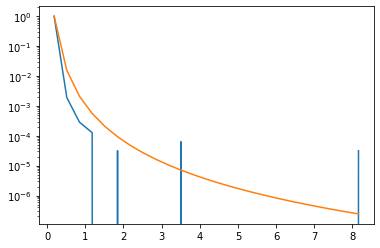

In [218]:
nN = np.linalg.norm(N)
y = 1.0/np.power(np.sin(x*np.pi/180/2),4.)
ny = np.linalg.norm(y)
plt.plot(x, N/nN)
plt.plot(x, y/ny)
plt.yscale("log")

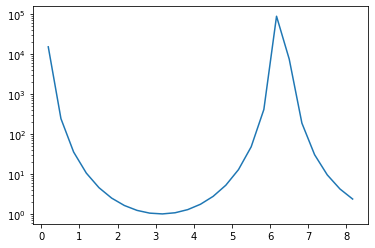

In [220]:
#plt.plot(x, N)
#plt.plot(np.asnumpy(x), np.asnumpy(1/np.power(np.sin(x/2),4.)))
plt.plot(x, 1/np.power(np.sin(x/2),4.))
plt.yscale("log")

In [221]:
plt.hist(np.asnumpy(tau_c*360.0/(2*np.pi)), bins=50, edgecolor='black')

AttributeError: module 'numpy' has no attribute 'asnumpy'

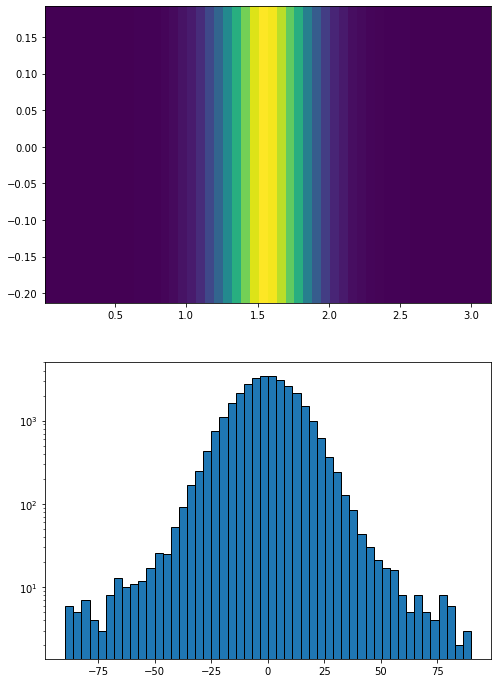

In [222]:
import cupy as np
fig=plt.figure(figsize=(8, 12))

plt.subplot(2,1,1)
#plt.hist2d(t_cyl, z_cyl, bins=[50,1])
plt.hist2d(np.asnumpy(t_cyl), np.asnumpy(z_cyl), bins=[50,1])

plt.subplot(2,1,2)
#plt.hist(t_cyl, bins=50, edgecolor='black')
plt.hist(np.asnumpy(t_cyl*360.0/(2*np.pi)-90.0), bins=50, edgecolor='black')
plt.yscale('log')
plt.show()

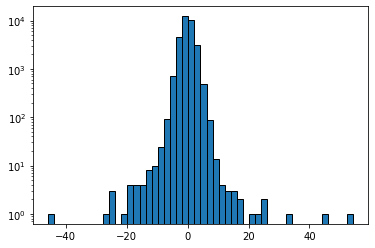

In [192]:
import cupy as cp
import numpy as np

N, edges, _ = plt.hist(cp.asnumpy(t_cyl*360.0/(2*np.pi)-90.0), bins=50, edgecolor='black')
plt.yscale("log")
plt.show()

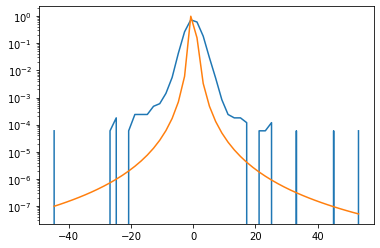

In [190]:
x = (edges[1:] + edges[:-1])/2
nN = np.linalg.norm(N)
y = 1.0/np.power(np.sin(x*np.pi/180/2),4.)
ny = np.linalg.norm(y)
plt.plot(x, N/nN)
plt.plot(x, y/ny)
plt.yscale("log")

### 3D view

ValueError: Either posA and posB, or path need to provided

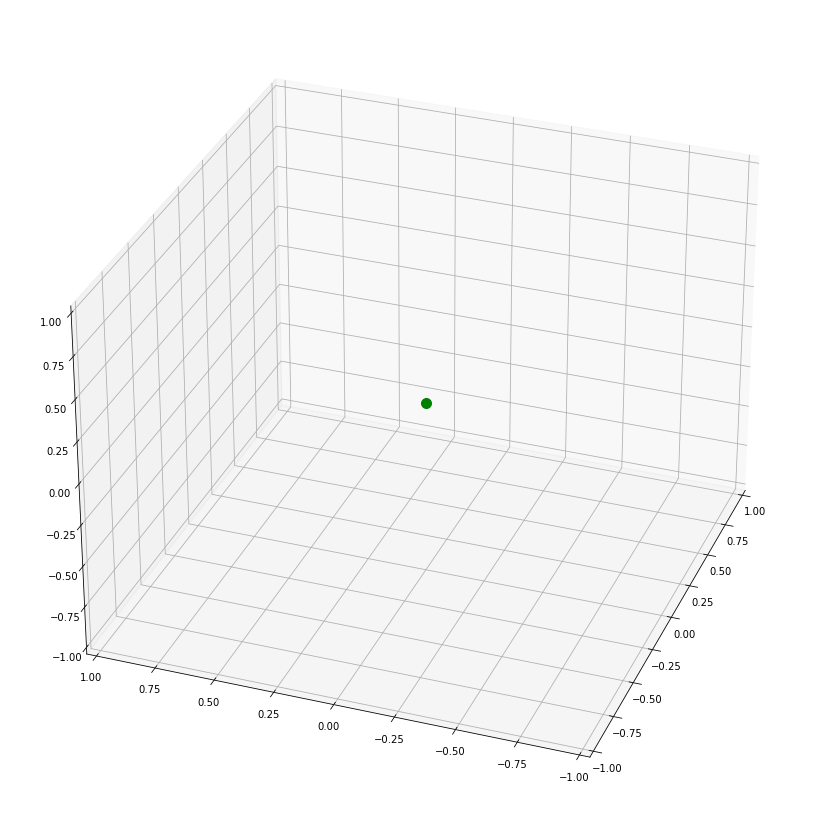

In [18]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations


fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')

def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

axisEqual3D(ax)        

ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)

ax.azim = -160
ax.elev = 30
# draw sphere
# u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
# x = np.cos(u)*np.sin(v)
# y = np.sin(u)*np.sin(v)
# z = np.cos(v)
# ax.plot_wireframe(x, y, z, color="r")

# draw a point
ax.scatter([0], [0], [0], color="g", s=100)

# draw a vector
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


class Arrow3D(FancyArrowPatch):

    def _init_(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch._init_(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

x = Arrow3D([-1, 1],  [0, 0],  [0, 0], mutation_scale=20, lw=1, arrowstyle="-|>", color="k")
y = Arrow3D( [0, 0], [-1, 1],  [0, 0], mutation_scale=20, lw=1, arrowstyle="-|>", color="k")
z = Arrow3D( [0, 0],  [0, 0], [-1, 1], mutation_scale=20, lw=1, arrowstyle="-|>", color="k")

u_x =   0#np.cos(np.pi/4)
u_y =   1#np.cos(np.pi/4)
u_z =   0.3#np.cos(np.pi/4)

t  = np.pi/4
a  = np.pi/4
ct = np.cos(t) 
st = np.sin(t) 
ca = np.cos(a)
sa = np.sin(a)

def Xr(u_x, u_y, u_z, t):
    v_x = + u_x*1 + u_y*0         + u_z*0
    v_y = + u_x*0 + u_y*np.cos(t) + u_z*1 - u_z*np.sin(t)
    v_z = + u_x*0 + u_y*np.sin(t) + u_z*0 + u_z*np.cos(t)
    return v_x, v_y, v_z

def Yr(u_x, u_y, u_z, t):
    v_x = + u_x*np.cos(t) + u_y*0 + u_z*np.sin(t)
    v_y = + u_x*0         + u_y*1 + u_z*0
    v_z = - u_x*np.sin(t) + u_y*0 + u_z*np.cos(t)
    return v_x, v_y, v_z

def Zr(u_x, u_y, u_z, t):
    v_x = + u_x*np.cos(t) - u_y*np.sin(t) - u_z*0
    v_y = + u_x*np.sin(t) + u_y*np.cos(t) + u_z*0
    v_z = + u_x*0         + u_y*0         + u_z*1
    return v_x, v_y, v_z
    

# y rotation for alpha z rotation tau
v_x, v_y, v_z = Yr(u_x,u_y,u_z, np.pi/4)
w_x, w_y, w_z = Zr(v_x,v_y,v_z, np.pi/4)

u = Arrow3D([0, u_x], [0, u_y], [0, u_z], mutation_scale=20, lw=1, arrowstyle="->",  color="r")
v = Arrow3D([0, v_x], [0, v_y], [0, v_z], mutation_scale=20, lw=1, arrowstyle="-|>", color="b")
w = Arrow3D([0, w_x], [0, w_y], [0, w_z], mutation_scale=20, lw=1, arrowstyle="-|>", color="c")

ax.add_artist(x)
ax.add_artist(y)
ax.add_artist(z)
ax.add_artist(u)
ax.add_artist(v)
ax.add_artist(w)

ax.set_xlabel('$X$', fontsize=20)
ax.set_ylabel('$Y$', fontsize=20)
ax.set_zlabel('$Z$', fontsize=20)
ax.auto_scale_xyz([-1, 1], [-1, 1], [-1, 1])
plt.show()